
# Tutorial: The Full Workflow: Tuning, Final Evaluation, and Preventing Data Leakage

Selamat datang di subchapter 3.5! Ini adalah puncak dari semua yang telah kita pelajari tentang evaluasi dan *tuning*. Di sini, kita akan menggabungkan `train_test_split`, *pipelines*, *hyperparameter tuning*, dan evaluasi akhir ke dalam satu alur kerja yang kohesif, kuat, dan benar secara metodologis.

Tujuan utama dari notebook ini adalah untuk menginternalisasi alur kerja yang benar untuk mencegah **data leakage**—kesalahan paling umum dan berbahaya dalam *machine learning* di mana informasi dari data uji secara tidak sengaja "bocor" ke dalam proses pelatihan.




---
### 1. Tujuan Pembelajaran

Di akhir notebook ini, Anda akan dapat:

* Mengimplementasikan alur kerja *machine learning* dari awal hingga akhir dengan benar.
* Menjelaskan mengapa `test set` harus benar-benar diisolasi sampai akhir.
* Menerapkan *hyperparameter tuning* hanya pada `training set`.
* Melakukan evaluasi akhir yang jujur pada model terbaik Anda menggunakan `test set`.




---
### 2. Aturan Emas: Isolasi Total Data Uji

Bayangkan Anda sedang mempersiapkan seorang siswa untuk ujian akhir nasional.

* **`Training Set`**: Ini adalah semua materi pelajaran, buku teks, dan soal-soal latihan yang Anda berikan kepada siswa untuk belajar.
* **`Test Set`**: Ini adalah **amplop tersegel** yang berisi soal ujian akhir yang sebenarnya.

**Data Leakage** terjadi jika Anda membiarkan siswa **mengintip isi amplop ujian** saat mereka sedang belajar. Tentu saja mereka akan mendapat nilai sempurna, tetapi itu tidak mencerminkan pemahaman mereka yang sebenarnya.

**Alur Kerja yang Benar:**
1.  **Bagi Data (Sekali Saja):** Di awal, bagi data Anda menjadi *training* dan *test set*.
2.  **Simpan Amplopnya:** Kunci `test set` di dalam brankas. Jangan pernah menggunakannya untuk *tuning*, analisis, atau bahkan *scaling*.
3.  **Latih Siswa:** Lakukan semua proses Anda—*preprocessing*, *cross-validation*, *hyperparameter tuning*—**HANYA** pada `training set`.
4.  **Ujian Akhir:** Setelah Anda memiliki satu model final terbaik, buka amplopnya dan evaluasi model tersebut **satu kali** pada `test set`. Skor inilah yang Anda laporkan sebagai performa model Anda.






---
### 3. Setup: Mempersiapkan Skenario

Kita akan mengikuti "Aturan Emas" dengan ketat.



In [3]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

# Muat data
housing = fetch_california_housing()
X, y = housing.data, housing.target

HTTPError: HTTP Error 403: Forbidden


#### Langkah 1: Bagi Data dan Kunci Test Set

Ini adalah satu-satunya `train_test_split` yang akan kita lakukan.



In [ ]:
# Sisihkan 20% data untuk ujian akhir
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Ukuran Training Set (untuk semua proses pelatihan & tuning): {X_train.shape}")
print(f"Ukuran Test Set (disimpan sampai akhir): {X_test.shape}")

Ukuran Training Set (untuk semua proses pelatihan & tuning): (16512, 8)
Ukuran Test Set (disimpan sampai akhir): (4128, 8)


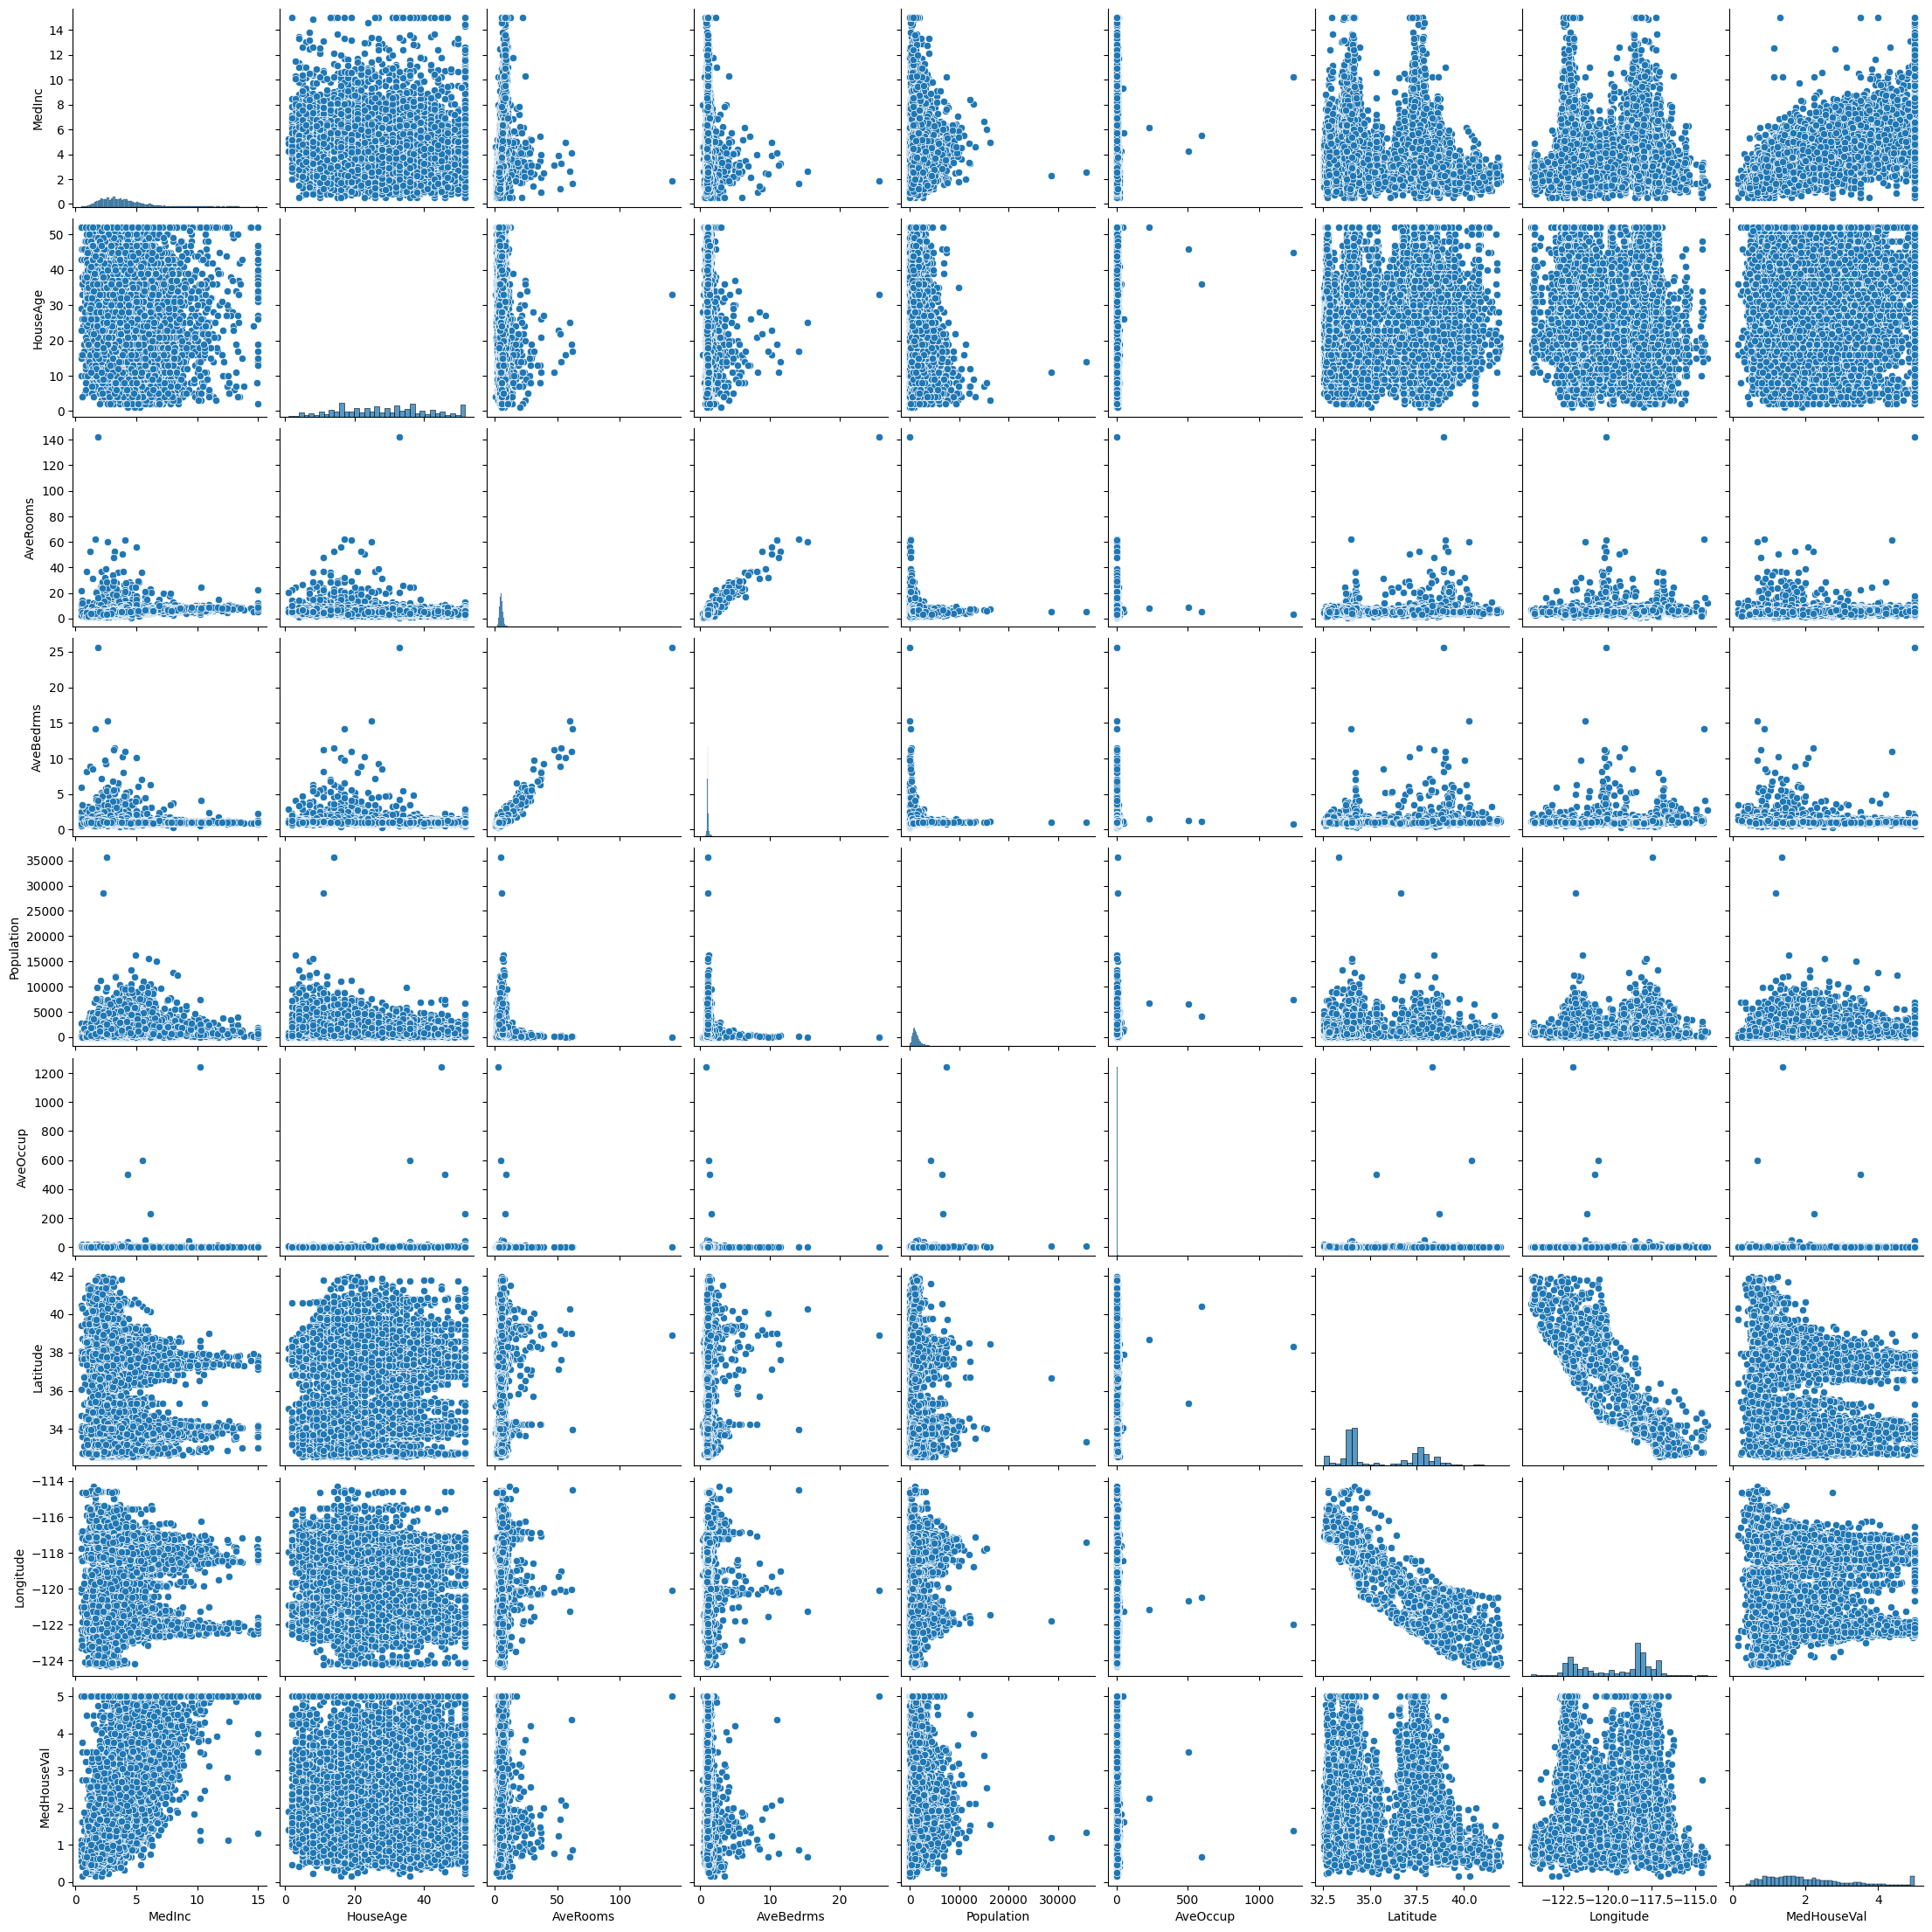

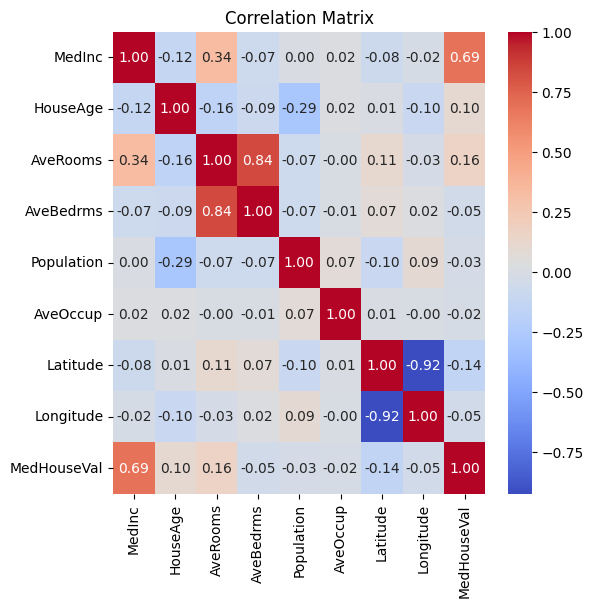

In [ ]:
# Buat DataFrame dari X_train dan y_train untuk visualisasi
df_train = pd.DataFrame(X_train, columns=housing.feature_names)
df_train['MedHouseVal'] = y_train

# Pair plot
sns.pairplot(df_train)
plt.show()

# Correlation plot (heatmap)
plt.figure(figsize=(6, 6))
corr_matrix = df_train.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


---
### 4. Langkah 2: Proses Pelatihan & Tuning (Hanya pada Training Set)

Sekarang kita akan melakukan semua pekerjaan kita—membangun pipeline dan *hyperparameter tuning*—hanya dengan menggunakan `X_train` dan `y_train`.




#### Mendefinisikan Pipeline dan Ruang Pencarian



In [ ]:
pipe_rf = Pipeline(
	[
		('scaler',StandardScaler()),
		('model',RandomForestRegressor(random_state=42))
	]
)

param_dist = {
	'model__n_estimators': randint(50, 200),
	'model__max_depth': randint(10, 30),
	'model__min_samples_leaf': randint(2, 10)
}


#### Menjalankan Hyperparameter Tuning



In [ ]:
random_search = RandomizedSearchCV(
	estimator=pipe_rf,
	param_distributions=param_dist,
	n_iter=20, # Coba 20 kombinasi acak
	cv=5,
	scoring='neg_mean_squared_error', # Kita akan tune berdasarkan MSE
	n_jobs=-1,
	random_state=42,
	verbose=1
)

print("memulai hyperparameter tuning pada training set saja")
random_search.fit(X_train,y_train)

memulai hyperparameter tuning pada training set saja
Fitting 5 folds for each of 20 candidates, totalling 100 fits


,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'model__max_depth': <scipy.stats....t 0x12e5c4410>, 'model__min_samples_leaf': <scipy.stats....t 0x12e5c4690>, 'model__n_estimators': <scipy.stats....t 0x12937a510>}"
,n_iter,20
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan



#### Menganalisis Hasil Tuning



In [ ]:
print(f"\nhyperparameter terbaik yang ditemukan: \n{random_search.best_params_}")

# best score dalam CV
best_cv_mse = -random_search.best_score_
best_cv_rmse = np.sqrt(best_cv_mse)

cv_results = random_search.cv_results_['mean_test_score']
std_rmse = np.std(np.sqrt(-cv_results))

print(f"standard deviasi RMSE cross_validation: {std_rmse:.4f}")
print(f"RMSE cross_validation: {best_cv_rmse:.4f}")


hyperparameter terbaik yang ditemukan: 
{'model__max_depth': 21, 'model__min_samples_leaf': 2, 'model__n_estimators': 98}
standard deviasi RMSE cross_validation: 0.0082
RMSE cross_validation: 0.5106



---
### 5. Langkah 3: Ujian Akhir (Evaluasi pada Test Set)

Kita sekarang memiliki model final terbaik kita, yang disimpan di `random_search.best_estimator_`. Saatnya membuka "amplop tersegel" dan melihat seberapa baik performanya pada data `X_test` dan `y_test`.



In [ ]:
final_model = random_search.best_estimator_

y_pred_test = final_model.predict(X_test)

final_mse = mean_squared_error(y_test,y_pred_test)
final_rmse = np.sqrt(final_mse)
final_r2 = r2_score(y_test,y_pred_test)

print("---- hasil evaluasi pada test set ----")
print(f"root mean squared error (RMSE): {final_rmse:.4f}")
print(f"r2 : {final_r2:.4f}")

---- hasil evaluasi pada test set ----
root mean squared error (RMSE): 0.5044
r2 : 0.8059



**Analisis Hasil:**

* RMSE hasil cross-validation pada *training set* adalah sekitar **0.5106**.
* RMSE pada *test set* adalah sekitar **0.5044**.

Nilai-nilai ini cukup dekat, yang merupakan pertanda baik! Ini menunjukkan bahwa model kita tidak *overfitting* secara signifikan dan memiliki kemampuan generalisasi yang baik. Skor yang kita dapatkan pada `test set` adalah estimasi yang jujur tentang bagaimana model ini akan berperforma pada data baru di dunia nyata.




---
### 6. Kesimpulan Tutorial

Alur kerja yang benar secara metodologis adalah kunci untuk membangun model *machine learning* yang andal. Selalu ingat:

1.  **Bagi data Anda menjadi `train` dan `test` di awal.**
2.  **Kunci `test set` Anda.** Lupakan keberadaannya untuk sementara waktu.
3.  **Lakukan semua pekerjaan Anda**—eksplorasi, *preprocessing*, *feature engineering*, dan *hyperparameter tuning*—**hanya menggunakan `train set`** (dengan *cross-validation*).
4.  Setelah Anda memiliki **satu model final**, evaluasi performanya **satu kali** pada `test set`.

Dengan mengikuti aturan ini, Anda memastikan bahwa hasil evaluasi Anda adalah cerminan yang jujur dari performa model Anda di dunia nyata.
